In [1]:
import sys
import os
import os
import numpy as np
import cv2
import mrcnn.config
import mrcnn.utils
import matplotlib.pyplot as plt
from mrcnn.model import MaskRCNN
from pathlib import Path
from IPython.display import Image

Using TensorFlow backend.


In [7]:
# Set up Colab Environment

IN_COLAB = 'google.colab' in sys.modules or not 'mrcnn' in sys.modules
HAS_DATASET = os.path.exists('mask_rcnn_coco.h5')
SAMPLE_IMAGE = 'https://i.imgur.com/AdPz4lX.jpg' # Leave this blank if you do not want to download an image
#SAMPLE_IMAGE_NAME = 'car.jpg' # Name of input file to be saved 

if(IN_COLAB):
  !pip install mrcnn

if(not HAS_DATASET):
  !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5 
    
if(len(SAMPLE_IMAGE)):
  !wget -O $SAMPLE_IMAGE_NAME $SAMPLE_IMAGE

/bin/sh: wget: command not found
/bin/sh: wget: command not found


In [10]:

# Configuration that will be used by the Mask-RCNN library
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  # COCO dataset has 80 classes + one background class
    DETECTION_MIN_CONFIDENCE = 0.6


# Filter a list of Mask R-CNN detection results to get only the detected cars / trucks
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck / bus, skip it
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)


# Root directory of the project
ROOT_DIR = Path(".")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, SAMPLE_IMAGE)


# Create a Mask-RCNN model in inference mode
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())

# Load pre-trained model
model.load_weights("mask_rcnn_coco.h5", by_name=True)

parked_car_boxes = None



# FOR IMAGE

Cars found in photo:
Car:  [ 316  236 1715 1970]
Car:  [  0   6 783 761]


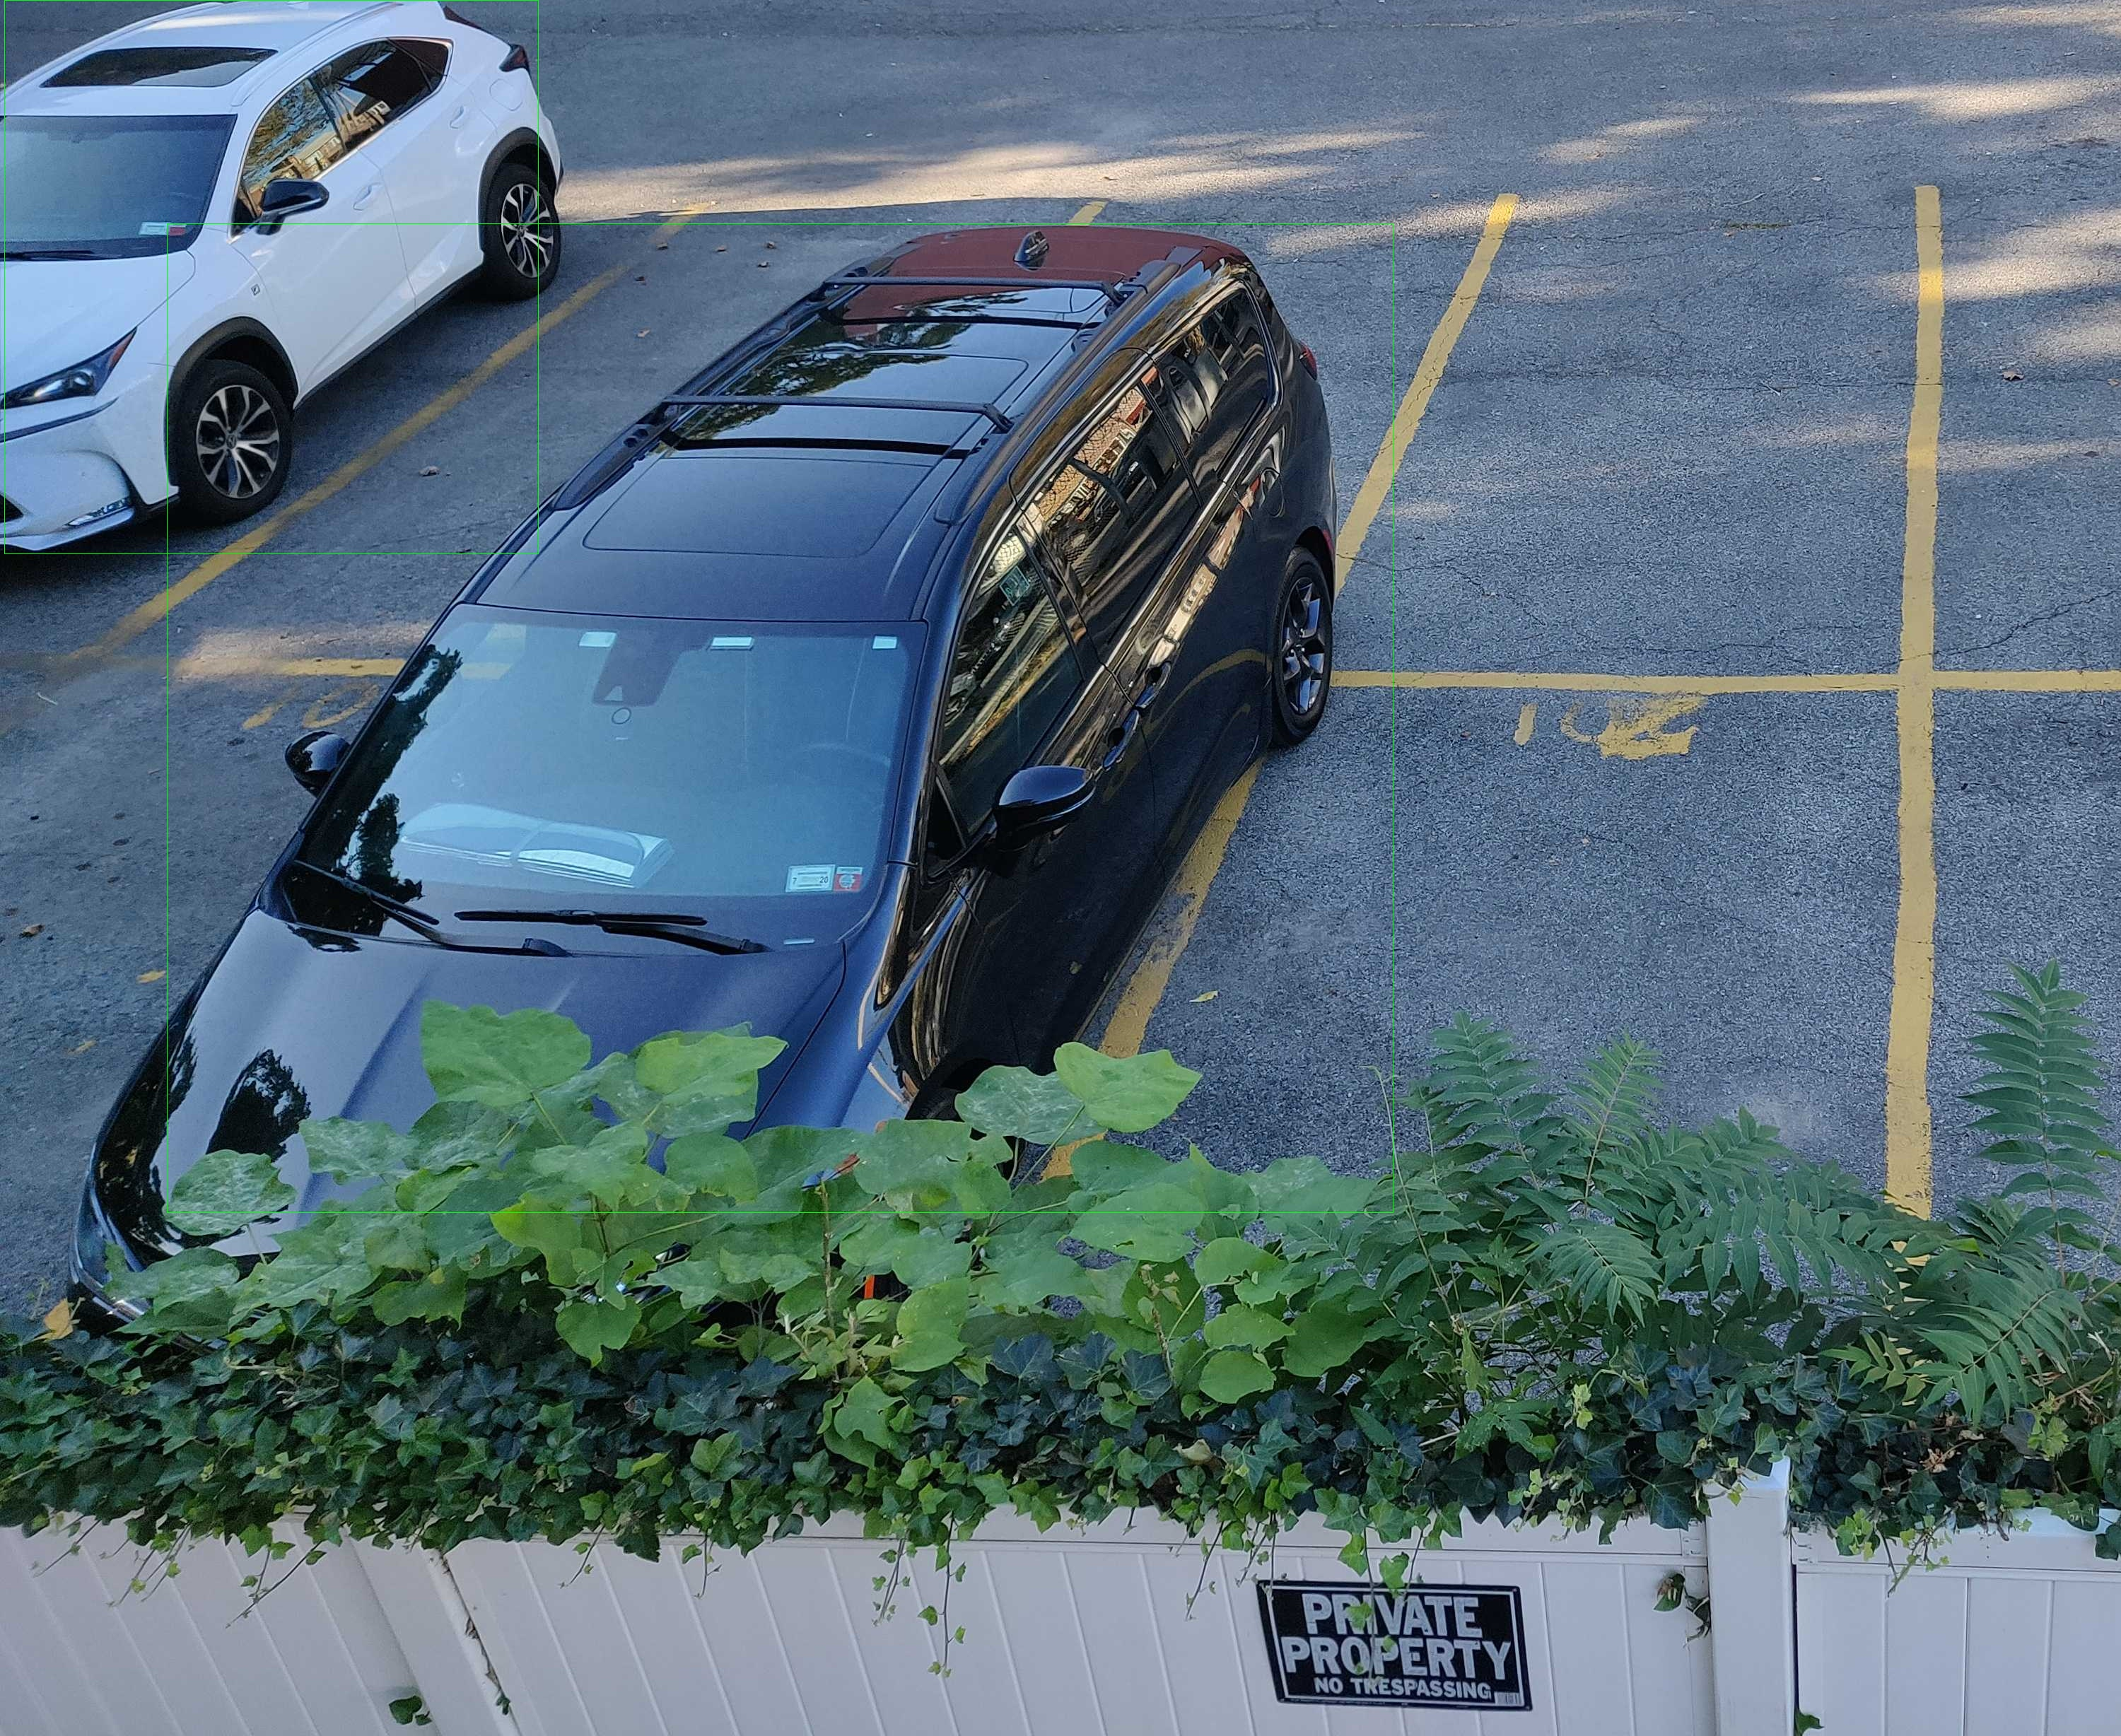

In [9]:
rgb= cv2.imread(IMAGE_DIR)
x = 0
y = 1000
h = 3000
w = 3000
crop = rgb[y:y+h, x:x+w]
    

# Run the image through the Mask R-CNN model to get results.
results = model.detect([crop], verbose=0)

# Mask R-CNN assumes we are running detection on multiple images.
# We only passed in one image to detect, so only grab the first result.
r = results[0]

# The r variable will now have the results of detection:
# - r['rois'] are the bounding box of each detected object
# - r['class_ids'] are the class id (type) of each detected object
# - r['scores'] are the confidence scores for each detection
# - r['masks'] are the object masks for each detected object (which gives you the object outline)

# Filter the results to only grab the car / truck bounding boxes
car_boxes = get_car_boxes(r['rois'], r['class_ids'])

print("Cars found in photo:")

# Draw each box on the frame
for box in car_boxes:
    print("Car: ", box)

    y1, x1, y2, x2 = box

        # Draw the box
    cv2.rectangle(crop, (x1, y1), (x2, y2), (0, 255, 0), 1)

    
cv2.imwrite('car_output.jpg', crop)
cv2.destroyAllWindows()
Image('car_output.jpg')


# Run the below cell only to remove the pre-trained model

In [6]:
os.remove('mask_rcnn_coco.h5')
print("Pretrained Model Removed from the folder, Download to again to run the model")

Pretrained Model Removed from the folder, Download to again to run the model
